In [89]:
import networkx as nx
import pandas as pd
import numpy as np
import random
import copy
import math
from sklearn_extra.cluster import KMedoids

def get_spread_attack_graph(G, n=100, phi=1, seed=42):
    num_nodes_to_select = int(len(G) * phi)

    if num_nodes_to_select < 2:
        return list(G.nodes)

    all_pairs_shortest_path_length = dict(nx.all_pairs_shortest_path_length(G))

    selected_nodes = []

    nodes_start = list(G.nodes)
    nodes = copy.deepcopy(nodes_start)
    random.seed(seed)
    random.shuffle(nodes)

    first_node = nodes.pop()
    selected_nodes.append(first_node)

    for _ in range(num_nodes_to_select - 1):
        max_distance = -1
        max_distance_node = None

        for node in nodes:
            min_distance = float("inf")
            for selected_node in selected_nodes:
                distance = all_pairs_shortest_path_length[selected_node][node]
                min_distance = min(min_distance, distance)

            if min_distance > max_distance:
                max_distance = min_distance
                max_distance_node = node

        selected_nodes.append(max_distance_node)
        nodes.remove(max_distance_node)
        
        if len(nodes) == 0:
            # If all nodes have an attack edge, restart
            assert phi >= 1
            nodes = copy.deepcopy(nodes_start)
            random.shuffle(nodes)

    total_nodes = len(G)
    print(selected_nodes)
    for i, s in enumerate(selected_nodes):
        G.add_edge(s, total_nodes + i)
        
def get_medoids(G, n_clusters):
    """
    Divide all honest cells into n_clusters clusters. The medoids will be the attacked nodes.
    """
    dist_matrix = np.array(nx.floyd_warshall_numpy(G))
    kmedoids = KMedoids(n_clusters=n_clusters, metric='precomputed', random_state=0).fit(dist_matrix)
    return kmedoids.medoid_indices_

def create_spread_attack_graph(G, attacked, max_degree):
    """
    Divide all attacked nodes into clusters of size max_degree at most and assign sybil nodes
    """
    dist_matrix = np.array(nx.floyd_warshall_numpy(G))
#     dist_matrix = dist_matrix[np.ix_(attacked, attacked)]
    unassigned = set(attacked)
    total_nodes = len(G)
    cluster_number = 1
    while unassigned:
        seed_node = random.choice(list(unassigned))
        unassigned.remove(seed_node)
        cluster = set([seed_node])
        for i in range(max_degree - 1):
            if not unassigned:
                break
            closest = find_closest_node(G, attacked, dist_matrix, unassigned)
            cluster.add(closest)
            unassigned.remove(closest)

        for n in cluster:
            G.add_edge(n, total_nodes + cluster_number)
        cluster_number += 1
        
def find_closest_node(G, nodes, dist_matrix, unassigned):
    closest_node = None
    closest_dist = float('inf')
    for node in G.nodes():
        if node in unassigned:
            dist_to_nodes = np.min(dist_matrix[node][list(nodes)])
            if dist_to_nodes < closest_dist:
                closest_node = node
                closest_dist = dist_to_nodes
    return closest_node

        
#     kmedoids = KMedoids(n_clusters=math.ceil(len(attacked)/max_degree), metric='precomputed', random_state=0).fit(dist_matrix)
#     labels = kmedoids.labels_
#     medoids = kmedoids.medoid_indices_
#     total_nodes = len(G)
#     print(total_nodes)
#     for i in range(len(attacked)):
#         print(attacked[i], total_nodes + labels[i])
#         G.add_edge(attacked[i], total_nodes + labels[i] + 1)
    

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 98 97 96]


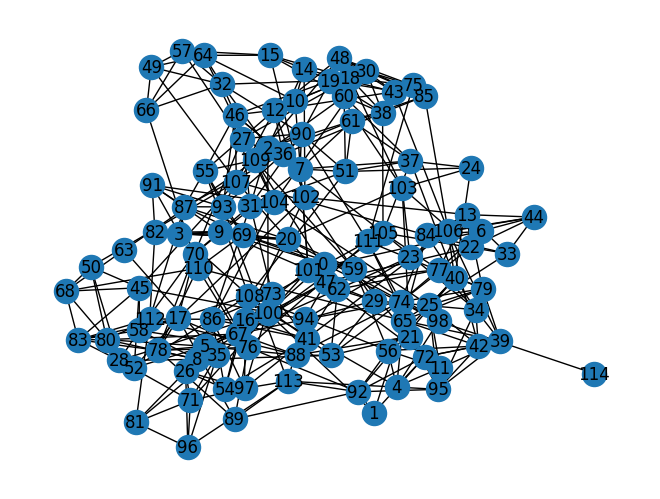

In [95]:
# Create graph with 99 honest nodes
# G = nx.random_geometric_graph(20, 2, seed=42)
# random.seed(126)

G = nx.random_geometric_graph(99, 0.2, seed=42)
random.seed(123)


# Set max degree for every node
max_degree = 7

for node in G.nodes:
    while G.degree(node) > max_degree:
        edges = list(G.edges(node))
        G.remove_edge(*edges[random.randint(0, len(edges) - 1)])
# nx.draw(G, with_labels=True)
phi = 1

attacked = get_medoids(G, int(len(G) * phi))
print(attacked)
create_spread_attack_graph(G, attacked, max_degree)


nx.draw(G, with_labels=True)
a = nx.adjacency_matrix(G)
from scipy.sparse import csr_matrix, find
find(a)
adj = []
for i in range(len(G)):
    for j in a[[i], :]:
        adj.append(j.toarray()[0])



In [97]:
pd.DataFrame(adj).to_csv("99_1_phi_v2.csv", index=None)

In [15]:
import pandas as pd 
adj =pd.read_csv("100.csv").values.tolist()

In [96]:
print(min(list(map(lambda x: sum(x), adj[:199]))))
print(max(list(map(lambda x: sum(x), adj[:199]))))

1
8


In [9]:
adj[0][9]

1

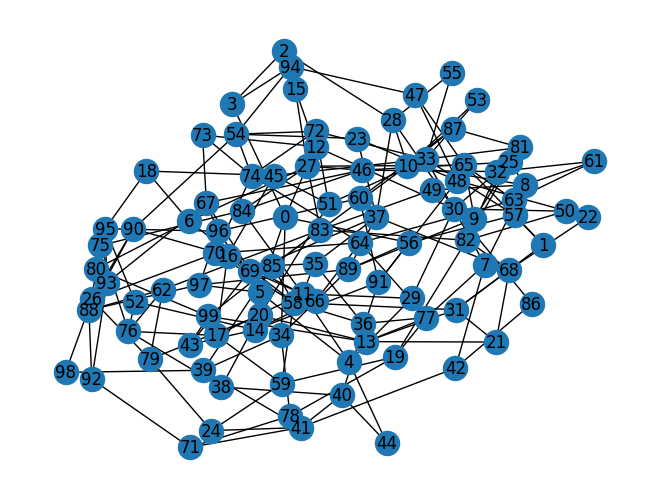

In [36]:
G = nx.watts_strogatz_graph(100, 4, 0.9, seed=42)
nx.draw(G, with_labels=True)
a = nx.adjacency_matrix(G)
from scipy.sparse import csr_matrix, find
find(a)
adj = []
for i in range(100):
    for j in a[[i], :]:
        adj.append(j.toarray()[0])


In [39]:
print(max(list(map(lambda x: sum(x), adj))))

8


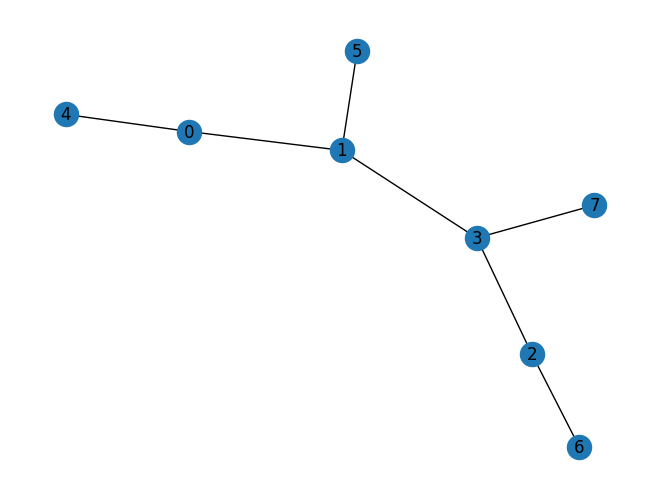

In [45]:
G = nx.random_geometric_graph(5, 0.4, seed=43)


for i in range(4):
    if G.has_edge(i, 4):
        G.remove_edge(i, 4)

for i in range(4):
    G.add_edge(i, i+4)

nx.draw(G, with_labels=True)

In [47]:



a = nx.adjacency_matrix(G)
from scipy.sparse import csr_matrix, find
find(a)
adj = []
for i in range(8):
    for j in a[[i], :]:
        adj.append(j.toarray()[0])
adj

[array([0, 1, 0, 0, 1, 0, 0, 0]),
 array([1, 0, 0, 1, 0, 1, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 1, 0]),
 array([0, 1, 1, 0, 0, 0, 0, 1]),
 array([1, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 1, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 0, 0])]

In [48]:
pd.DataFrame(adj).to_csv("4_sybil.csv", index=None)

In [ ]:
G = nx